In [1]:
import scipy
from scipy.linalg import hadamard
import math
import numpy as np
import matplotlib
from math import factorial
from matplotlib import pyplot as plt
from sympy.functions.combinatorial.numbers import stirling
from scipy.stats import norm
from scipy.misc import comb
import random
%matplotlib inline

In [2]:
matplotlib.rc('font', family='DejaVu Sans')

figure_size = (16, 8)

## Task 1

In [3]:
def get_max_coeffs(function_generator, number_of_iterations):
    n = round(math.log(function_generator().shape[0], 2))
    Hadamard_matrix = np.asmatrix(hadamard(2**n))
    
    Hadamard_Walsh_max_coeffs = []
    Fourier_max_coeffs = []
    
    for _ in range(number_of_iterations):
        function = function_generator()
        Fourier_spectre = Hadamard_matrix * function
        Hadamard_Walsh_spectre = Hadamard_matrix * (1 - 2 * function)
        
        Hadamard_Walsh_max_coeffs.append(abs(max(Hadamard_Walsh_spectre[1:], key=abs)[0, 0]))
        Fourier_max_coeffs.append(abs(max(Fourier_spectre[1:], key=abs)[0, 0]))
    return (Fourier_max_coeffs, Hadamard_Walsh_max_coeffs)

In [4]:
def generate_random_boolean_function(n):
    return np.asmatrix(np.random.randint(2, size=2**n)).T

In [5]:
def print_max_coeffs_figures(coeffs_distributions):
    Fourier_max_coeffs = coeffs_distributions[0]
    Hadamard_Walsh_max_coeffs = coeffs_distributions[1]
    
    x = list(set(Fourier_max_coeffs))
    x.sort()
    y = [Fourier_max_coeffs.count(value) for value in x]
    
    plt.figure(figsize=figure_size)
    plt.title('Распределение максимальных по модулю коэффициентов Фурье')
    plt.xlabel('Абсолютное значение коэффициентов')
    plt.ylabel('Количество коэффициентов')
    plt.margins(x=0.1)  # Задание отступа справа и слева между самим графиком и рамкой.
    plt.stem(x, y, linefmt='b-', markerfmt='b.')
    
    #################
    
    x = list(set(Hadamard_Walsh_max_coeffs))
    x.sort()
    y = [Hadamard_Walsh_max_coeffs.count(value) for value in x]
    
    plt.figure(figsize=figure_size)
    plt.title('Распределение максимальных по модулю коэффициентов Адамара-Уолша')
    plt.xlabel('Абсолютное значение коэффициентов')
    plt.ylabel('Количество коэффициентов')
    plt.margins(x=0.1)
    plt.stem(x, y, linefmt='b-', markerfmt='b.')

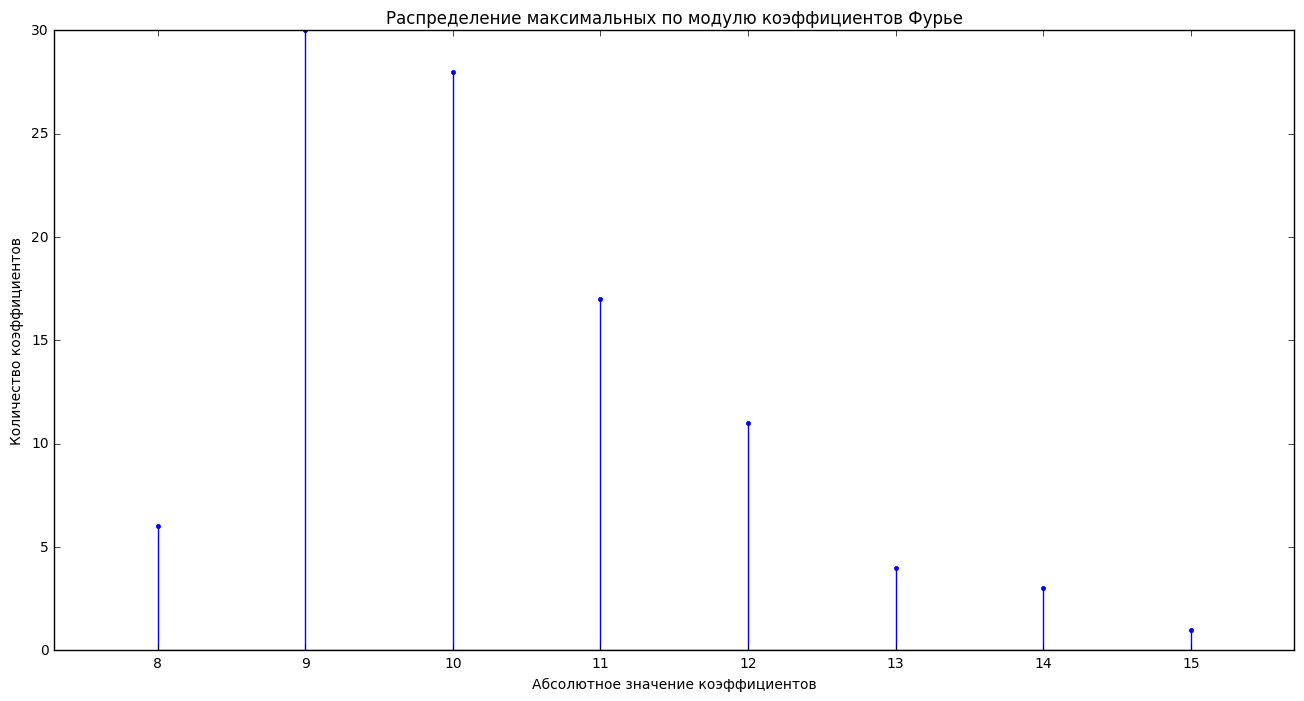

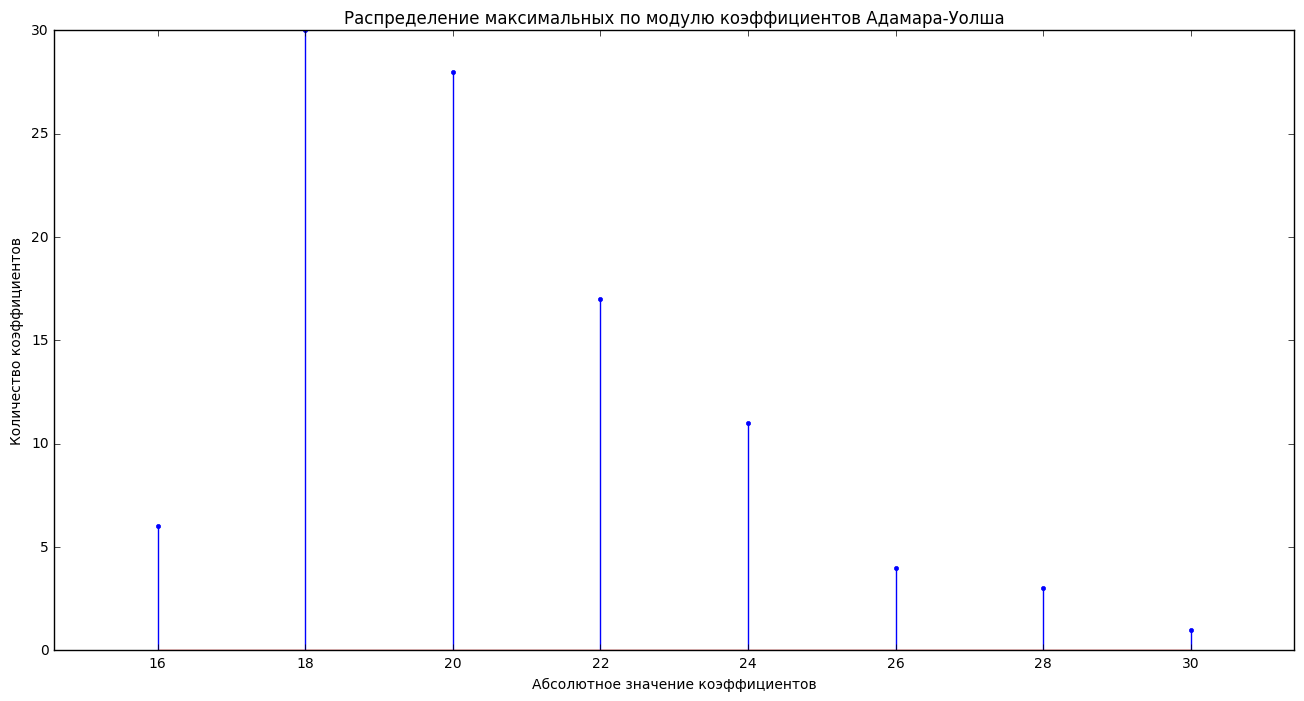

In [6]:
print_max_coeffs_figures(get_max_coeffs(lambda: generate_random_boolean_function(6), 100))

## Task 3
(before Task 2)

In [7]:
def get_random_boolean_function_with_fixed_weight(n, weight):
    function = np.asmatrix(np.zeros(2**n, dtype=int))
    
    i = 0
    while i < weight:
        position = random.randint(0, 2**n - 1)
        if function[0, position] == 0:
            function[0, position] = 1
            i += 1
    return function.T

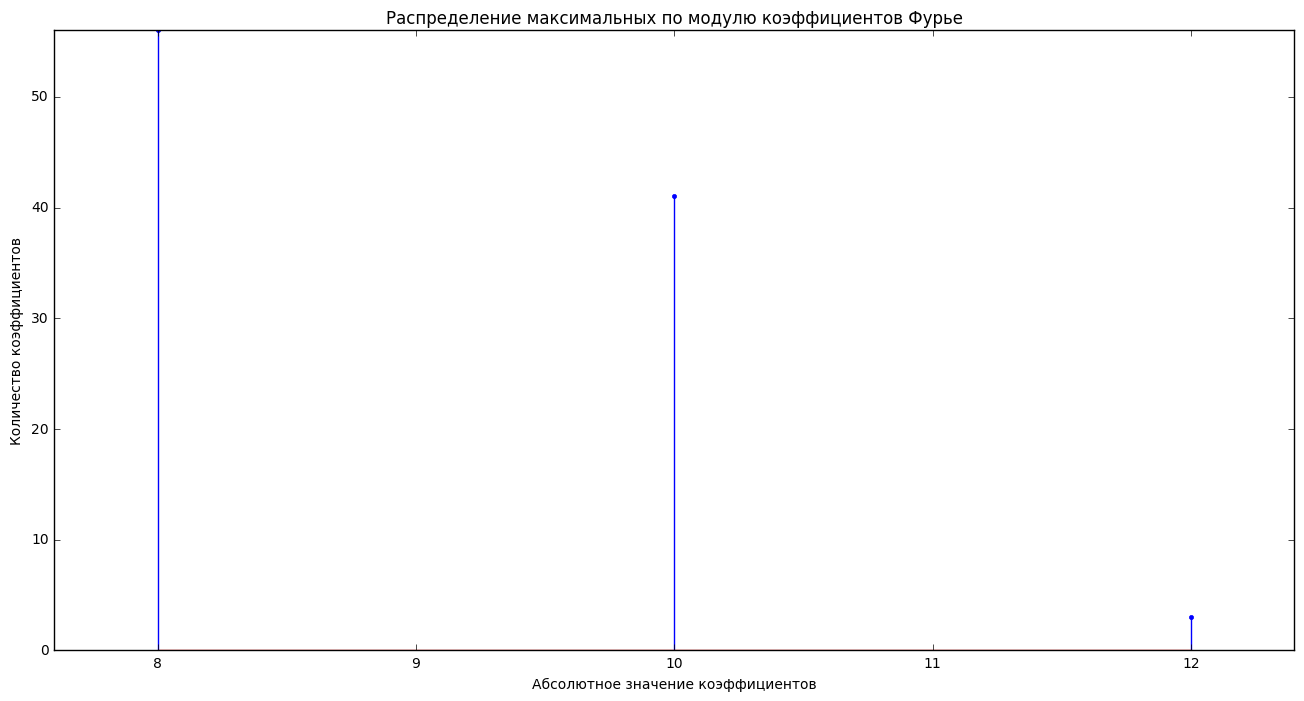

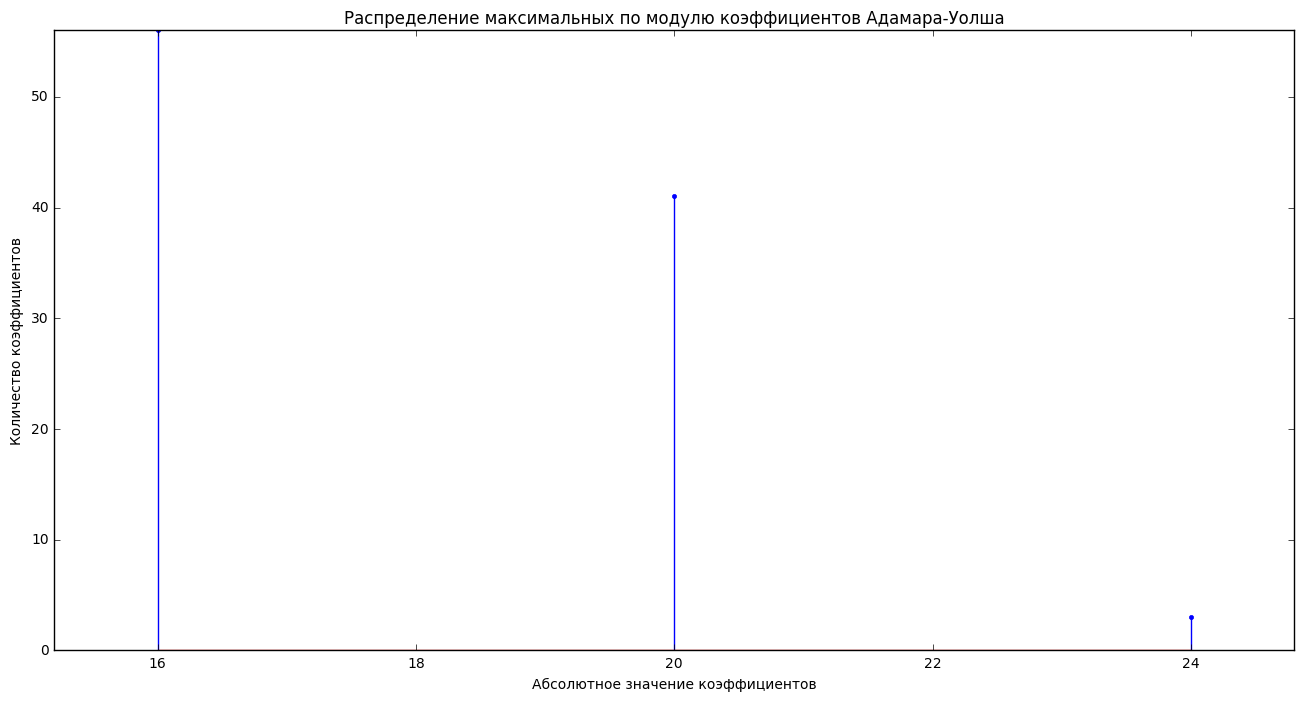

In [8]:
get_random_boolean_function_weight_16 = lambda: get_random_boolean_function_with_fixed_weight(6, 16)
print_max_coeffs_figures(get_max_coeffs(get_random_boolean_function_weight_16, 100))

## Task 2

In [9]:
def get_function_to_Zhegalkin_coeffs_matrix_G(n):
    if n in get_function_to_Zhegalkin_coeffs_matrix_G.cache:
        return get_function_to_Zhegalkin_coeffs_matrix_G.cache[n]
    
    G_n_prev = get_function_to_Zhegalkin_coeffs_matrix_G(n - 1)
    result = np.asmatrix(np.vstack([np.hstack([G_n_prev, np.zeros(G_n_prev.shape, dtype=int)]),\
                                    np.hstack([G_n_prev, G_n_prev])]))
    
    get_function_to_Zhegalkin_coeffs_matrix_G.cache[n] = result
    return result

get_function_to_Zhegalkin_coeffs_matrix_G.cache = {0: np.matrix([1], dtype=int)}

In [10]:
def get_random_boolean_linear_function(n):
    linear_coeffs = np.random.randint(2, size=n)
    while not linear_coeffs.any():
        linear_coeffs = np.random.randint(2, size=n)
    
    Zhegalkin_coeffs = np.zeros(2**n, dtype=int)
    for i in range(n):
        Zhegalkin_coeffs[1 << i] = linear_coeffs[i]
    Zhegalkin_coeffs = np.asmatrix(Zhegalkin_coeffs).T
    
    return (get_function_to_Zhegalkin_coeffs_matrix_G(n) * Zhegalkin_coeffs) % 2

In [11]:
def corrupt_function(function, number_of_bits_to_change):
    """Портит указанное число бит функции.
    Для тестов."""
    for _ in range(number_of_bits_to_change):
        position = random.randint(0, function.shape[0] - 1)
        function[position, 0] = 1 - function[position, 0]
    return function

In [19]:
def corrupt_function_on_fixed_position(function, position_to_change):
    """Исправляет 1 бит на указанной позиции."""
    function[position_to_change, 0] = 1 - function[position_to_change, 0]
    return function

In [13]:
def conjunction_to_str(conjunction):
    """Конвертирует конъюнкцию, представляемую вектором входящих переменных, в строковую запись.
    [1, 3, 4] -> x1x3x4
    с нижними индексами в Libre Office."""
    
    return ''.join(map(lambda var: "x_{{{}}}".format(var), conjunction))  # Господи, питон, серьёзно?

In [14]:
def str_Zhegalkin_polynomial(Zhegalkin_coeffs):
    n = round(math.log(len(Zhegalkin_coeffs), 2))
    included_conjunctions = []
    
    for i in range(len(Zhegalkin_coeffs)):
        if Zhegalkin_coeffs[i]:
            variable_vector = []
            included_variables = bin(i)[2:].zfill(n)
            for j in range(len(included_variables)):
                if included_variables[j] != '0':
                    variable_vector.append(j + 1)
            included_conjunctions.append(variable_vector)
    
    included_conjunctions.sort(key=lambda conj: (len(conj), conj))
    return ' ⊕ '.join(map(conjunction_to_str, included_conjunctions))

In [15]:
# Test
zhegalkin = np.array([0, 1, 0, 1, 1, 1, 0, 1])
str_Zhegalkin_polynomial(zhegalkin)

'x_{1} ⊕ x_{3} ⊕ x_{1}x_{3} ⊕ x_{2}x_{3} ⊕ x_{1}x_{2}x_{3}'

In [16]:
def Zhegalkin_polynom_and_Hadamard_Walsh_plot_for_function(function):
    n = round(math.log(function.shape[0], 2))
    
    Zhegalkin_coeffs = (get_function_to_Zhegalkin_coeffs_matrix_G(n) * function) % 2
    print("Многочлен Жегалкина:", str_Zhegalkin_polynomial(Zhegalkin_coeffs), sep='\n')
    
    Hadamard_Walsh_spectre = np.asmatrix(hadamard(2**n)) * (1 - 2 * function)
    print('Отладочная информация; уникальные значения сразу после преобразования Адамара-Уолша:')
    print(list(set(Hadamard_Walsh_spectre.A1)))
    
    Hadamard_Walsh_spectre = Hadamard_Walsh_spectre.A1[1:]
    Hadamard_Walsh_spectre = list(map(abs, Hadamard_Walsh_spectre))
    Hadamard_Walsh_spectre.sort()
    
    plt.figure(figsize=figure_size)
    plt.title('Абсолютные значения коэффициентов преобразования Адамара-Уолша для линейной функции, исправленной на одном входном векторе')
    plt.xlabel('')
    plt.ylabel('Абсолютное значение коэффициента')
    plt.plot(np.arange(1, 2**n, 1), Hadamard_Walsh_spectre, 'bo')

Многочлен Жегалкина нелинейной функции:
x_{2} ⊕ x_{3} ⊕ x_{2}x_{3} ⊕ x_{1}x_{2}x_{3}
Отладочная информация; уникальные значения сразу после преобразования Адамара-Уолша:
[2, -2, 6]


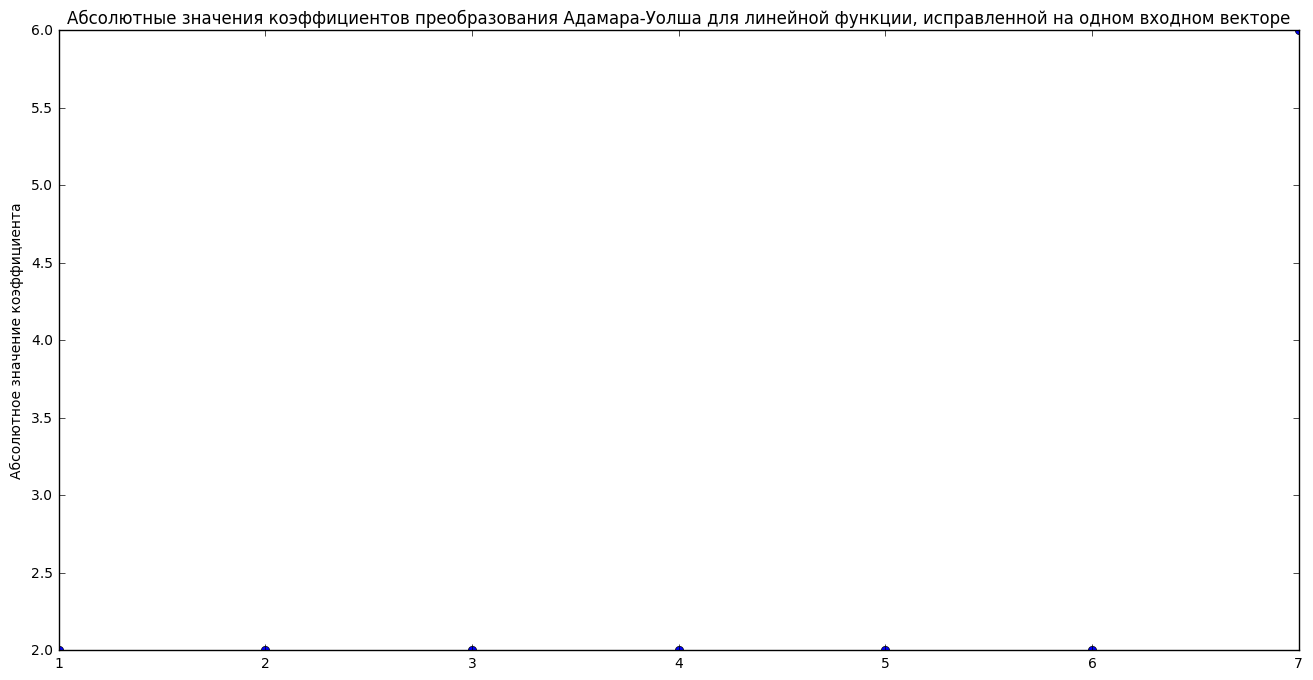

In [22]:
position_to_change = 2**10 - 5  # Меняется 1020-ый бит (отсчет с единицы).
function_to_study = corrupt_function_on_fixed_position(get_random_boolean_linear_function(10), position_to_change)
Zhegalkin_polynom_and_Hadamard_Walsh_plot_for_function(function_to_study)

Многочлен Жегалкина нелинейной функции:
x_{1} ⊕ x_{3} ⊕ x_{1}x_{3}
Отладочная информация; уникальные значения сразу после преобразования Адамара-Уолша:
[0, -4, 4]


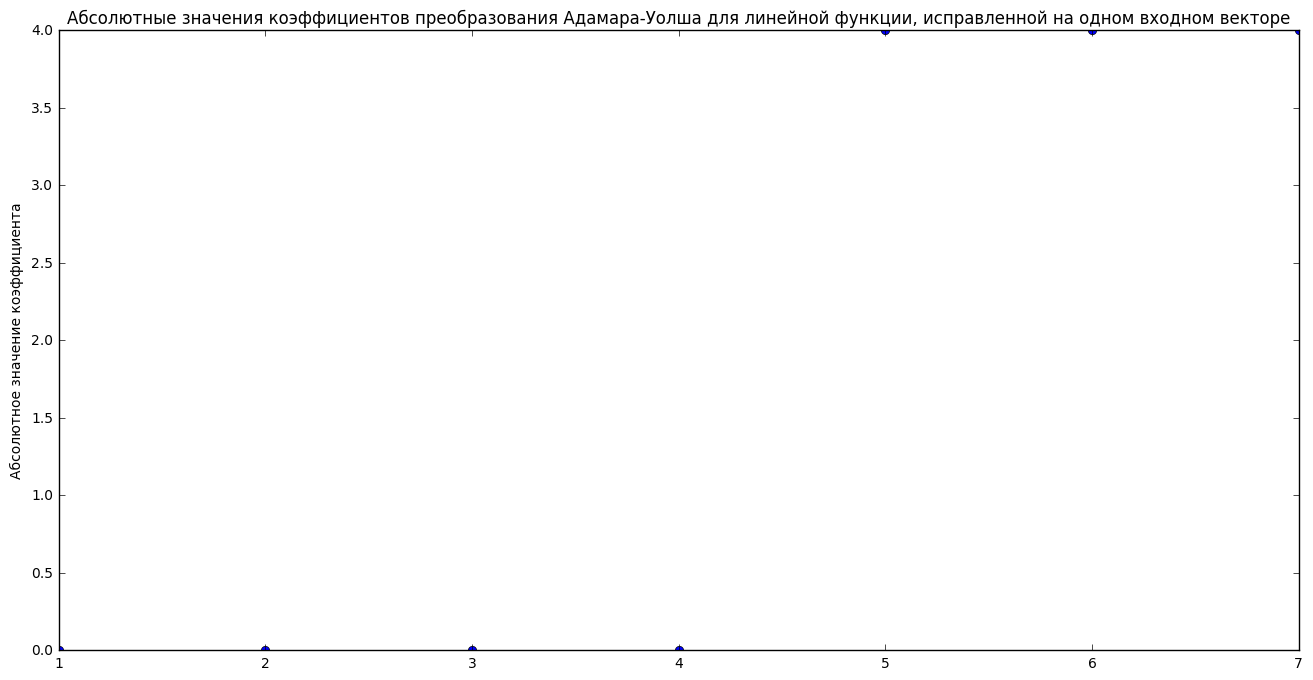

In [24]:
# Тесты.
function_to_study = corrupt_function(get_random_boolean_linear_function(3), 100)
Zhegalkin_polynom_and_Hadamard_Walsh_plot_for_function(function_to_study)

In [25]:
hadamard(2**3)

array([[ 1,  1,  1,  1,  1,  1,  1,  1],
       [ 1, -1,  1, -1,  1, -1,  1, -1],
       [ 1,  1, -1, -1,  1,  1, -1, -1],
       [ 1, -1, -1,  1,  1, -1, -1,  1],
       [ 1,  1,  1,  1, -1, -1, -1, -1],
       [ 1, -1,  1, -1, -1,  1, -1,  1],
       [ 1,  1, -1, -1, -1, -1,  1,  1],
       [ 1, -1, -1,  1, -1,  1,  1, -1]])

In [27]:
function = get_random_boolean_linear_function(3)
function

matrix([[0],
        [1],
        [1],
        [0],
        [1],
        [0],
        [0],
        [1]])

In [28]:
Fourier_spectre = hadamard(2**3) * function
Fourier_spectre

matrix([[ 4],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [-4]])